This notebook provides a visualisation of the raw data for the monoisotope, and shows the curve that was fitted to find the RT apex.
It relies on the following files from BAM:
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@3.211.113.236:~/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

Note that sequences_metrics_df contains unclassified features - it may contain features classified as decoys from particular runs. In this notebook we rely on the 'analyse the isotope intensity adjustment by peptide' notebook to identify sequences of interest in particular runs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)
MERGED_LIBRARY_SEQUENCE_ATTRIBS_FILE_NAME = "{}/coordinate-estimators/merged-run-library-sequence-attribs.pkl".format(EXPERIMENT_DIR)


In [5]:
# this is the ground truth for the coordinate estimator training, so we will use it here to identify the 'right' peak
merged_df = pd.read_pickle(MERGED_LIBRARY_SEQUENCE_ATTRIBS_FILE_NAME)

In [6]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select * from features order by run_name', db_conn)
db_conn.close()

In [7]:
sequences_df.sample(10)

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,monoisotopic_mass,monoisotopic_mz_centroid,monoisotopic_mz_delta_ppm,number_of_isotopes,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted
212589,EEECHFYAGGQVYPGEASR,3,8,0,"{""mono_mz"": 729.313138218121, ""scan_apex"": 724...",729.312964,0.000003,1.376563,-0.000667,-0.009357,...,2184.919722,729.313850,0.975919,5,491.078850,718,190719_Hela_Ecoli_1to1_10,1to1,1,10
125804,HENYGLM[15.9949]PLNGVLR,2,19,0,"{""mono_mz"": 814.9144904115706, ""scan_apex"": 44...",814.914276,0.006936,-0.677793,-0.021130,-0.006279,...,1627.813914,814.914233,-0.315753,5,676.577105,438,190719_Hela_Ecoli_1to1_06,1to1,1,10
230395,YNPMYSEPVDQEYLPEELR,2,8,0,"{""mono_mz"": 1186.5415631747019, ""scan_apex"": 7...",1186.541176,0.000127,1.006648,0.007607,-0.068254,...,2371.071170,1186.542861,1.093905,4,805.267277,67,190719_Hela_Ecoli_1to1_10,1to1,1,7
178401,NSGSCLGGDEIFLLCDK,2,10,0,"{""mono_mz"": 942.9291378848164, ""scan_apex"": 29...",942.926940,0.000003,-0.096353,-0.000953,0.000906,...,1883.843898,942.929225,0.092219,7,818.237049,300,190719_Hela_Ecoli_1to1_08,1to1,1,10
106558,LQKPTDSTASSR,2,18,0,"{""mono_mz"": 645.8364317080409, ""scan_apex"": 68...",645.836026,0.007413,0.731638,0.001608,-0.021370,...,1289.659256,645.836904,0.731556,5,709.317493,669,190719_Hela_Ecoli_1to1_05,1to1,1,9
119703,DEVITWVDTIVK,2,19,0,"{""mono_mz"": 709.3818662925504, ""scan_apex"": 61...",709.382276,0.000005,1.748214,0.000554,-0.006150,...,1416.751871,709.383211,1.896085,6,979.948990,611,190719_Hela_Ecoli_1to1_06,1to1,1,10
164604,AGKPVICATQMLESMIK,3,10,0,"{""mono_mz"": 626.3280091576829, ""scan_apex"": 80...",626.327964,0.000003,-0.727496,-0.000103,0.000393,...,1875.960833,626.327554,-0.727497,7,918.282148,801,190719_Hela_Ecoli_1to1_08,1to1,1,9
138903,VPDYWYPQDLQAR,2,19,0,"{""mono_mz"": 825.8994352385787, ""scan_apex"": 41...",825.899176,0.000003,0.390899,-0.000566,0.005840,...,1649.784579,825.899565,0.157702,3,723.190851,419,190719_Hela_Ecoli_1to1_06,1to1,1,9
22764,YNAPTSHVTPSVK,2,11,0,"{""mono_mz"": 700.8635690219039, ""scan_apex"": 60...",700.862076,0.000003,-0.946285,0.007132,0.005649,...,1399.711258,700.862905,-0.947295,5,312.486579,613,190719_Hela_Ecoli_1to1_01,1to1,1,7
196858,KTEAPAAPAAQETK,2,2,0,"{""mono_mz"": 706.872597427707, ""scan_apex"": 664...",706.872626,0.000003,0.579118,0.000318,-0.009022,...,1411.731462,706.873007,0.579118,5,208.943638,659,190719_Hela_Ecoli_1to1_09,1to1,1,10


In [8]:
selected_sequence = 'FIQQTYPSGGEEQAQYCR'
selected_sequence_charge = 2

In [9]:
# where was this sequence in the ground truth?
sequence_source_attribs_df = merged_df[(merged_df.sequence == selected_sequence) & (merged_df.charge == selected_sequence_charge)]


#### plot the monoisotopic peaks for all the runs for the selected sequence

In [10]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_df = pd.read_sql_query('select * from features where sequence==\'{}\' and charge=={} order by run_name'.format(selected_sequence,selected_sequence_charge), db_conn)
db_conn.close()

In [11]:
print("sequence was extracted from {} runs".format(len(selected_sequence_df)))

sequence was extracted from 10 runs


In [12]:
selected_sequence_df['log_intensity'] = np.log2(selected_sequence_df.intensity)

#### calculate the maximum flattened-to-rt intensity over the first three isotopes so we can set all the plot axes to be the same range

In [19]:
selected_sequence_df['max_mono_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.mono_filtered_points_l)]), axis=1)


In [20]:
selected_sequence_df['max_iso_1_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_1_filtered_points_l)]), axis=1)


In [21]:
selected_sequence_df['max_iso_2_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_2_filtered_points_l)]), axis=1)


In [22]:
sequence_intensity_max = np.max([selected_sequence_df.max_mono_filtered_intensity.max(), selected_sequence_df.max_iso_1_filtered_intensity.max(), selected_sequence_df.max_iso_2_filtered_intensity.max()])


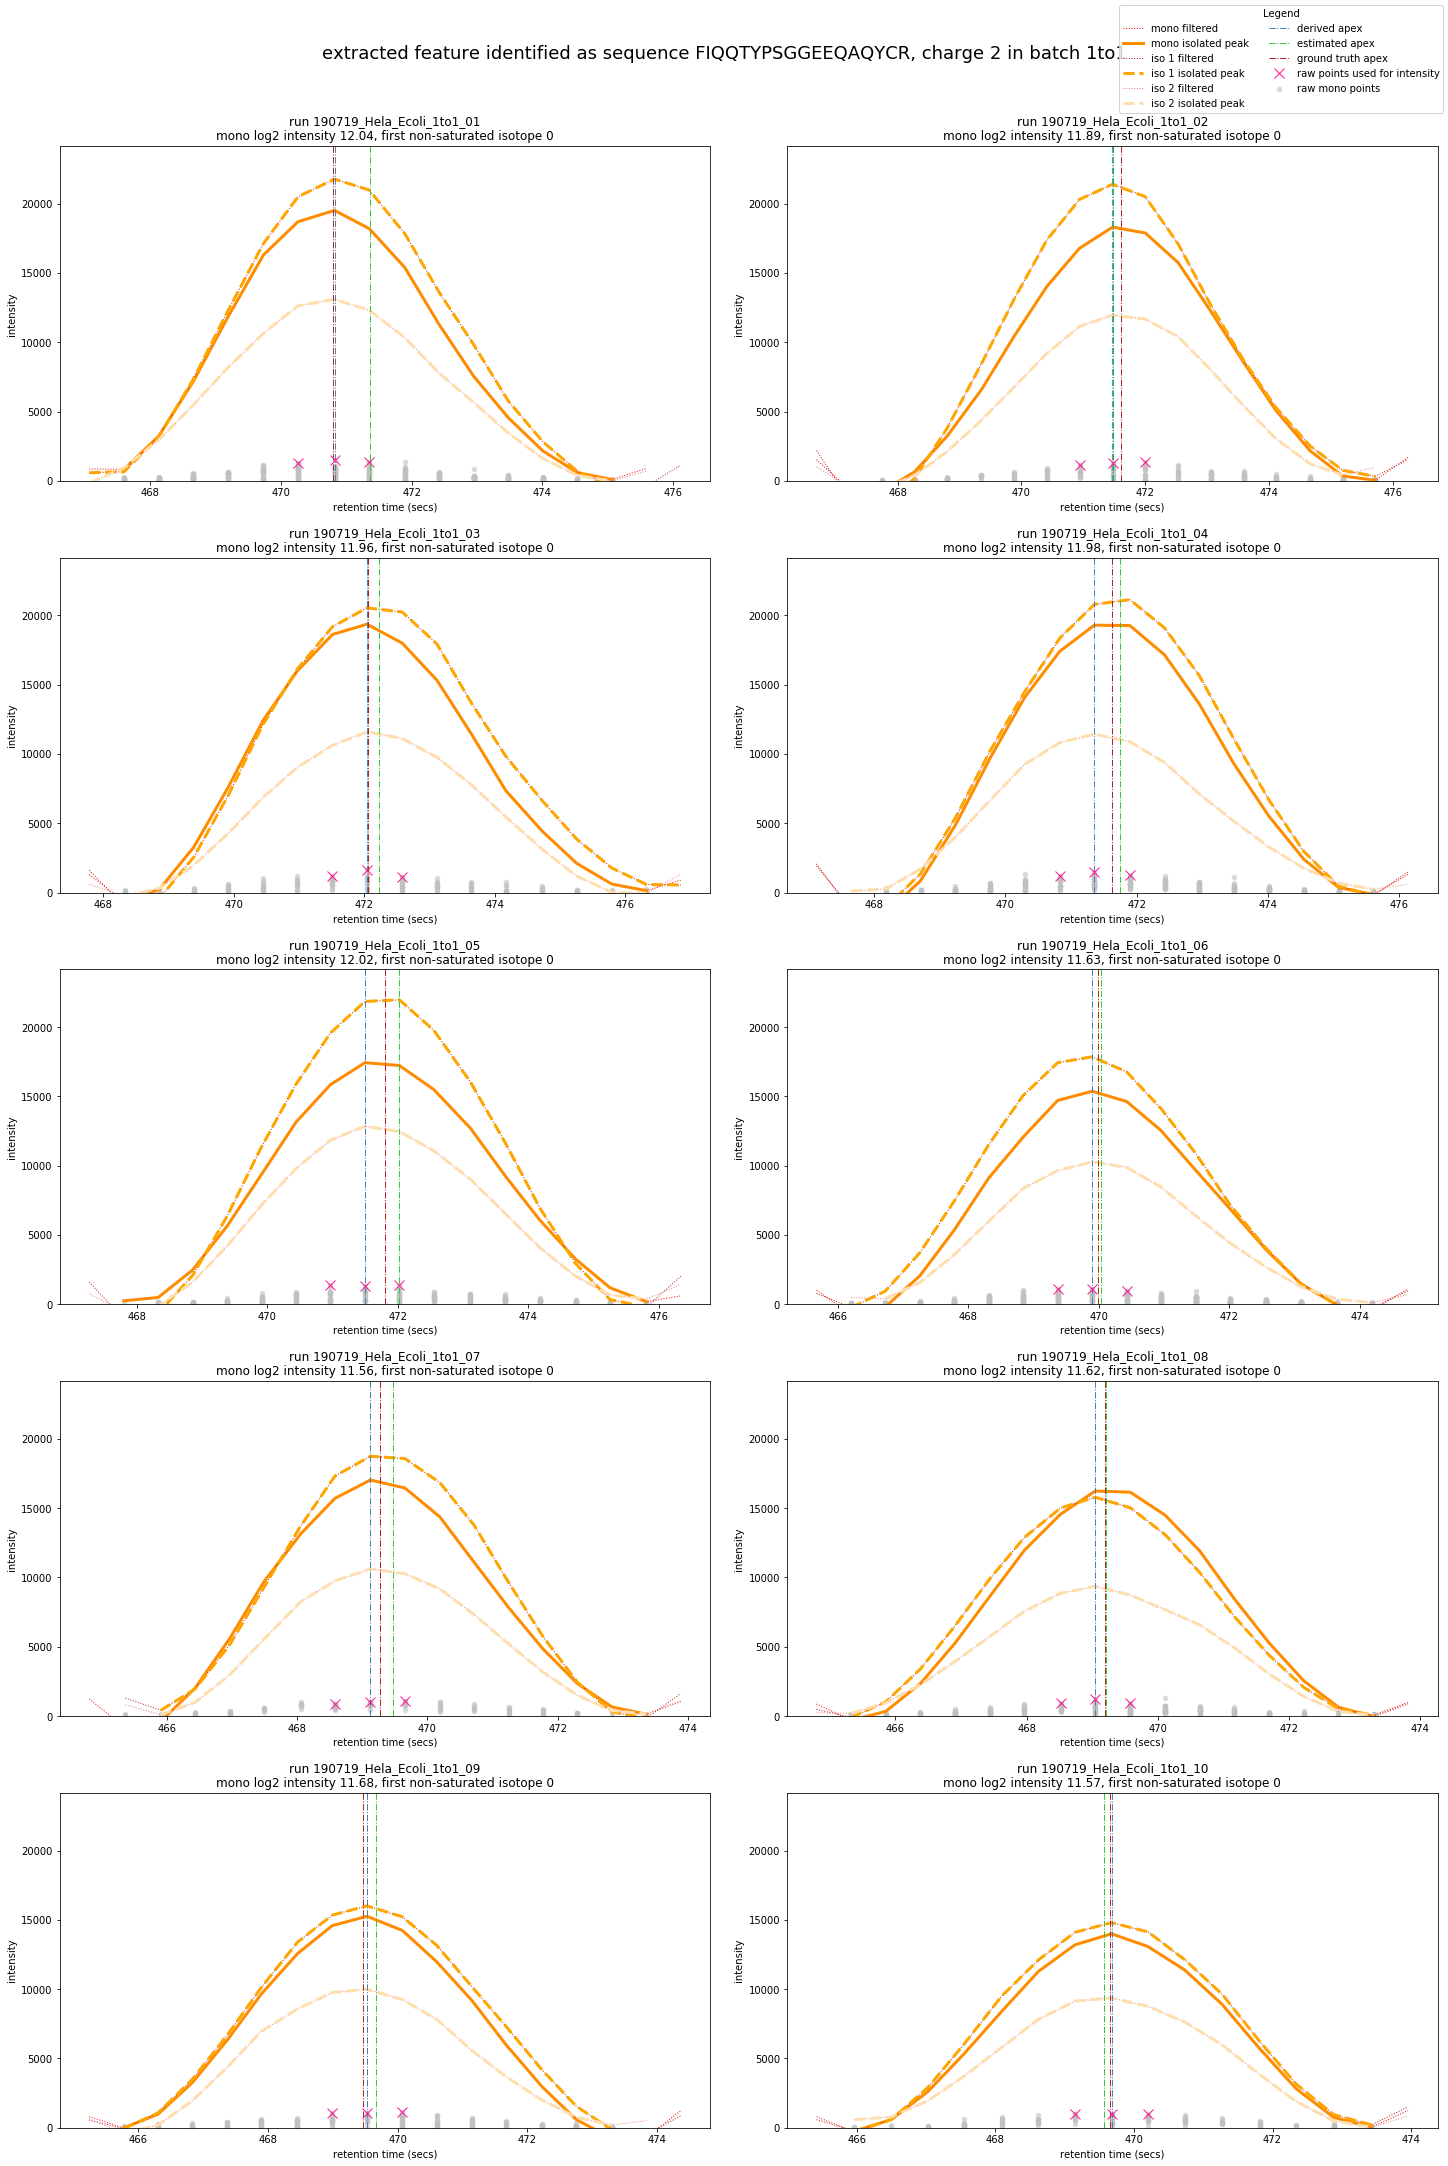

In [24]:
selected_batch = '1to1'

f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

max_labels = 0
for row_idx,row in enumerate(selected_sequence_df[selected_sequence_df.batch == selected_batch].itertuples()):
    r = int(row_idx / 2)
    c = row_idx % 2
    
    ax = axarr[r,c]  # row, column
    ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(row.run_name, round(row.log_intensity,2), int(row.isotope_idx_not_in_saturation)))
    
    isotopes_df = pd.DataFrame(row.isotope_intensities_l, columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])
    mono_raw_points_df = pd.DataFrame(isotopes_df.iloc[0].isotope_points, columns=['mz','scan','frame_id','retention_time_secs','intensity'])

    mono_filtered_points_df = pd.DataFrame(json.loads(row.mono_filtered_points_l))
    isotope_1_filtered_points_df = pd.DataFrame(json.loads(row.isotope_1_filtered_points_l))
    isotope_2_filtered_points_df = pd.DataFrame(json.loads(row.isotope_2_filtered_points_l))    

    mono_rt_lower,mono_rt_upper = json.loads(row.mono_rt_bounds)
    mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
    mono_rt_apex_derived = row.rt_apex
    estimated_rt_apex = json.loads(row.target_coords)['rt_apex']
    
    isotope_1_rt_lower,isotope_1_rt_upper = json.loads(row.isotope_1_rt_bounds)
    isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]
    
    isotope_2_rt_lower,isotope_2_rt_upper = json.loads(row.isotope_2_rt_bounds)
    isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

    ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

    # isotope 0
    ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
    ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

    # isotope 1
    ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
    ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

    # isotope 2
    ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
    ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

    # apexes
    ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
    ax.axvline(estimated_rt_apex, color='limegreen', lw=1.0, ls='-.', label='estimated apex')
    if len(sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)]) > 0:
        sequence_source_rt = sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)].iloc[0].run_rt
        ax.axvline(sequence_source_rt, color='firebrick', lw=1.0, ls='-.', label='ground truth apex')

    # highlight the points used to calculate intensity
    frame_maximums_l = []
    for rt,group_df in mono_raw_points_df.groupby('retention_time_secs'):
        frame_maximums_l.append(group_df.loc[group_df.intensity.idxmax()])
    frame_maximums_df = pd.DataFrame(frame_maximums_l)
    frame_maximums_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
    frame_maximums_df.reset_index(drop=True, inplace=True)
    frame_maximums_df['rt_delta'] = np.abs(frame_maximums_df.retention_time_secs - mono_rt_apex_derived)
    apex_idx = frame_maximums_df.rt_delta.idxmin()
    apex_idx_minus_one = max(0, apex_idx-1)
    apex_idx_plus_one = min(len(frame_maximums_df)-1, apex_idx+1)
    summed_intensity = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity.sum()
    ax.plot(frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].retention_time_secs, frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity, marker='x', color='deeppink', linestyle='', linewidth=1, ms=10, label='raw points used for intensity')
        
    # set up axes
    ax.set_ylim((0,sequence_intensity_max*1.1))
    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('intensity')
    
    # make a legend from all possible labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_labels:
        max_labels = len(labels)
        superset_handles = handles
        superset_labels = labels

f.legend(superset_handles, superset_labels, loc='upper right', ncol=2, title="Legend", fancybox=True)

plt.show()